# BERT fastai Multi-Label Classification

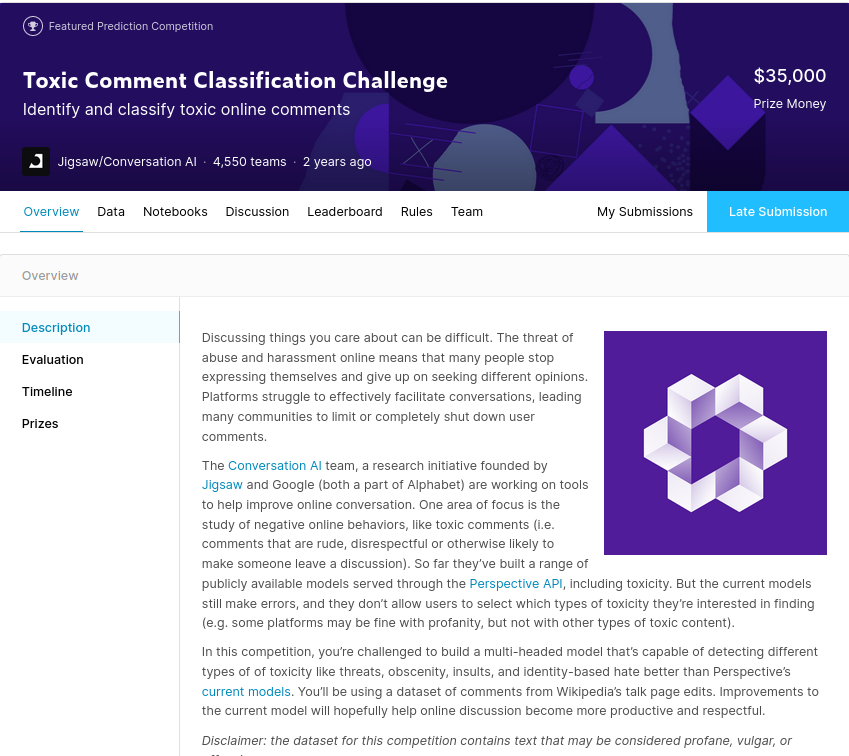

In [9]:
from IPython.display import Image
home = Path('/home/wyquek/Documents/Kaggle/Toxic Comment Classification Challenge')
Image(home/"Image/ToxicCommentOverview.png")

In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=32,
    discriminative=False,
    max_seq_len=256,
)

In [4]:
bert_tok = BertTokenizer.from_pretrained(config.bert_model_name,)

class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]
    
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])        

100%|██████████| 231508/231508 [00:00<00:00, 4259808.95B/s]


In [5]:
DATA_ROOT = Path("../input")
train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv.zip", "test.csv.zip"]]
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
X_train, X_val = train_test_split(train,test_size = 0.3)
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))


label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
databunch = TextDataBunch.from_df(".", X_train, X_val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

# Model

In [8]:
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

100%|██████████| 407873900/407873900 [00:08<00:00, 46130931.18B/s]


In [9]:
loss_func = nn.BCEWithLogitsLoss()

In [10]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)
if config.use_fp16: learner = learner.to_fp16()

In [11]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


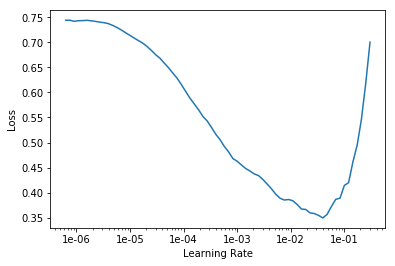

In [12]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(1, slice(1e-4))

## Prediction

In [14]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [15]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [17]:
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv.zip")
if config.testing: sample_submission = sample_submission.head(test.shape[0])
sample_submission[label_cols] = test_preds
sample_submission.to_csv("predictions.csv", index=False)

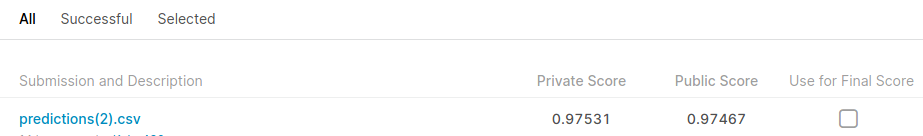

In [10]:
Image(home/"Image/score_bert_fastai_factored.png")

Reference : [ BERT with fastai notebook on Jigsaw Toxic Comments by keitakurita](https://github.com/keitakurita/Practical_NLP_in_PyTorch/blob/master/fastai/bert_with_fastai.ipynb).